####  **Import Libraries and modules**

In [0]:
import numpy as np
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras import backend as K

from keras.datasets import mnist
from matplotlib import pyplot as plt
%matplotlib inline

from google.colab import drive

drive.mount('/content/gdrive')
dir="/content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign5/"

!ls

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive	sample_data


### Load pre-shuffled MNIST data into train and test sets
Plotting a sample image from the dataset 

11493376/11490434 [==============================] - 2s 0us/step
(60000, 28, 28)


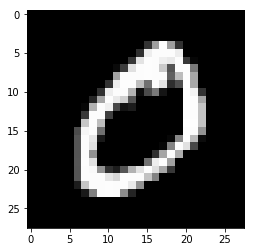

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print (x_train.shape)

plt.imshow(x_train[1], cmap='gray')

In [0]:
X_train = x_train.reshape(x_train.shape[0], 28, 28,1)
X_test = x_test.reshape(x_test.shape[0], 28, 28,1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Image standardisation
X_train /= 255
X_test /= 255

print(X_train.shape)
# Row 15 of second image
print(X_train[1,15,:,0])

(60000, 28, 28, 1)
[0.         0.         0.         0.         0.         0.
 0.29803923 0.9647059  0.9882353  0.4392157  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.99215686 0.9882353  0.5803922  0.
 0.         0.         0.         0.        ]


One hot encoding the labels from training and test set. Each 1d label is converted to 10d sparse matrix. Eg, digit 2 becomes [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]

In [0]:
print(y_train[1])
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Y_train[1]

0


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

#### Image normalisation

In [0]:
# Entire dataset mean and standard deviation
print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (X_train.mean(), X_train.std(), X_test.mean(), X_test.std()))

# Create generator to normalize images
# feature-wise is per-dataset, sample-wise is per-image
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# Calculate mean, var on training dataset, required if featurewise_center/featurewise_std_normalization set to True
datagen.fit(X_train)
print('Train data generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

Statistics train=0.131 (0.308), test=0.133 (0.310)
Train data generator mean=0.131, std=0.308


In [0]:
batch_size = 128

# get batch of the training set
train_iterator = datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=True, seed=42) # default is true
batchX, batchy = train_iterator.next()

valid_iterator = datagen.flow(X_test, Y_test, batch_size=batch_size, shuffle=True, seed=42)

print('Batches train=%d, test=%d' % (len(train_iterator), len(valid_iterator)))

Batches train=469, test=79


In [0]:
print(batchX.shape)
print(batchX[1,15,:,0])

(128, 28, 28, 1)
[-0.42407304 -0.42407304 -0.42407304 -0.42407304 -0.42407304 -0.42407304
 -0.42407304 -0.42407304 -0.42407304  0.39051074  2.0069501   1.2050945
  1.2050945   1.2050945   1.2050945  -0.42407304 -0.42407304 -0.42407304
  2.0069501   2.821534    2.821534    1.2050945  -0.42407304 -0.42407304
 -0.42407304 -0.42407304 -0.42407304 -0.42407304]


In [0]:
def build_model():
  model = Sequential()

  model.add(Conv2D(16, kernel_size=(3, 3), use_bias=False, input_shape=(28,28,1))) #26
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(32, (3, 3), use_bias=False)) #24
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(10, (1, 1), activation='relu', use_bias=False))
  model.add(MaxPooling2D(pool_size=(2, 2)))#12

  model.add(Conv2D(16, (3, 3), use_bias=False))#10
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(16, (3, 3), use_bias=False))#8
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(16, (3, 3), use_bias=False))#6
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(16, (3, 3), use_bias=False))#4
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.1))

  model.add(Conv2D(10, (4, 4))) 

  model.add(Flatten())
  model.add(Activation('softmax'))
  
  return model

# custom_model = build_model()
# custom_model.summary()

#### With std. loss and LR - best val. accuracy at epoch 20 is 99.47% (train acc. 99.26%)

In [0]:
custom_model = build_model()
custom_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

custom_model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator),                     
                    validation_data=valid_iterator, validation_steps=len(valid_iterator),
                    epochs=20, verbose=1)

Epoch 1/20
469/469 [==============================] - 14s 30ms/step - loss: 0.3951 - acc: 0.8819 - val_loss: 0.1079 - val_acc: 0.9659
Epoch 2/20
469/469 [==============================] - 11s 24ms/step - loss: 0.0827 - acc: 0.9750 - val_loss: 0.0576 - val_acc: 0.9816
Epoch 3/20
469/469 [==============================] - 12s 25ms/step - loss: 0.0600 - acc: 0.9815 - val_loss: 0.0357 - val_acc: 0.9884
Epoch 4/20
469/469 [==============================] - 11s 24ms/step - loss: 0.0497 - acc: 0.9846 - val_loss: 0.0331 - val_acc: 0.9893
Epoch 5/20
469/469 [==============================] - 11s 24ms/step - loss: 0.0433 - acc: 0.9861 - val_loss: 0.0292 - val_acc: 0.9902
Epoch 6/20
469/469 [==============================] - 11s 24ms/step - loss: 0.0404 - acc: 0.9872 - val_loss: 0.0287 - val_acc: 0.9912
Epoch 7/20
469/469 [==============================] - 11s 24ms/step - loss: 0.0384 - acc: 0.9879 - val_loss: 0.0226 - val_acc: 0.9927
Epoch 8/20
469/469 [==============================] - 12s 25ms

In [0]:
init_lr = 0.003

def scheduler(epoch, lr):
  return round(init_lr * 1/(1 + 0.319 * epoch), 10)

new_lr = LearningRateScheduler(scheduler, verbose=1)

#### With std. loss and custom LR - best val. accuracy at epoch 19 is 99.48% (train acc. 99.45%)

In [0]:
custom_model = build_model()
custom_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=init_lr), metrics=['accuracy'])

custom_model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator),                     
                    validation_data=valid_iterator, validation_steps=len(valid_iterator),
                    epochs=20, verbose=1, callbacks=[new_lr])

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
469/469 [==============================] - 15s 32ms/step - loss: 0.2271 - acc: 0.9295 - val_loss: 0.0635 - val_acc: 0.9787
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
469/469 [==============================] - 12s 25ms/step - loss: 0.0637 - acc: 0.9796 - val_loss: 0.0389 - val_acc: 0.9874
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
469/469 [==============================] - 12s 25ms/step - loss: 0.0522 - acc: 0.9839 - val_loss: 0.0364 - val_acc: 0.9888
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
469/469 [==============================] - 12s 25ms/step - loss: 0.0440 - acc: 0.9862 - val_loss: 0.0342 - val_acc: 0.9891
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
469/469 [==============================] - 12s 25ms/step - loss: 0.0390 - acc: 0.9881

In [0]:
lamda=0.02
m = X_train.shape[0]

def custom_loss(lamda):
  model_layers = custom_model.layers # type list where each el is Conv2D obj etc.
  #print(model_layers)
  reg_wts = 0
  
  for idx, layer in enumerate(model_layers):
    layer_wts = model_layers[idx].get_weights() # type list
    #print(len(layer_wts), layer_wts)
    
    if len(layer_wts) > 0: # activation, dropout layers do not have any weights
      layer_wts = model_layers[idx].get_weights()[0] #type ndarray, 3,3,1,16 : layer1 output
      reg_wts += np.sum(layer_wts**2)
      
  print("Reg. loss", reg_wts)    
  reg_wts = reg_wts * (lamda/(2*m))
      
  def total_loss(y_true, y_pred):   
    return K.categorical_crossentropy(y_true, y_pred) + reg_wts
  
  return total_loss
      
  

#### With custom loss and custom LR - 2 values of lambda were tried.

1. **Lambda 0.01** - best val. accuracy at epoch 16 is 99.59% (train acc. 99.32%) This is better, so keeping this.
2. **Lambda 0.02** - best val. accuracy at epoch 18 is 99.44% (train acc. 99.33%)



In [0]:
custom_model = build_model()
custom_model.compile(loss=custom_loss(lamda=0.01), optimizer=Adam(lr=init_lr), metrics=['accuracy'])

custom_model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator),                     
                    validation_data=valid_iterator, validation_steps=len(valid_iterator),
                    epochs=20, verbose=1, callbacks=[new_lr])

Reg. loss 222.47710072994232
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
469/469 [==============================] - 18s 38ms/step - loss: 0.2319 - acc: 0.9282 - val_loss: 0.0625 - val_acc: 0.9817
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
469/469 [==============================] - 12s 26ms/step - loss: 0.0611 - acc: 0.9811 - val_loss: 0.0306 - val_acc: 0.9892
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
469/469 [==============================] - 12s 25ms/step - loss: 0.0500 - acc: 0.9845 - val_loss: 0.0314 - val_acc: 0.9895
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
469/469 [==============================] - 12s 26ms/step - loss: 0.0410 - acc: 0.9869 - val_loss: 0.0315 - val_acc: 0.9890
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
469/469 [==============================] - 12s 25ms/step

In [0]:
custom_model = build_model()
custom_model.compile(loss=custom_loss(0.02), optimizer=Adam(lr=init_lr), metrics=['accuracy'])

print(lamda)
custom_model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator),                     
                    validation_data=valid_iterator, validation_steps=len(valid_iterator),
                    epochs=20, verbose=1, callbacks=[new_lr])

Reg. loss 222.95394575595856
0.02
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
469/469 [==============================] - 17s 36ms/step - loss: 0.2417 - acc: 0.9255 - val_loss: 0.0671 - val_acc: 0.9775
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
469/469 [==============================] - 12s 25ms/step - loss: 0.0650 - acc: 0.9797 - val_loss: 0.0446 - val_acc: 0.9860
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
469/469 [==============================] - 12s 25ms/step - loss: 0.0508 - acc: 0.9840 - val_loss: 0.0346 - val_acc: 0.9890
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
469/469 [==============================] - 12s 26ms/step - loss: 0.0438 - acc: 0.9860 - val_loss: 0.0390 - val_acc: 0.9870
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
469/469 [==============================] - 12s 25ms

## Final run for 40 epochs with lambda 0.01

In [0]:
custom_model = build_model()
custom_model.compile(loss=custom_loss(lamda=0.01), optimizer=Adam(lr=init_lr), metrics=['accuracy'])

file = dir + "Assign5-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

custom_model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator),                     
                    validation_data=valid_iterator, validation_steps=len(valid_iterator),
                    epochs=40, verbose=1, callbacks=[new_lr, checkpoint])

Reg. loss 223.21972465515137
Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
469/469 [==============================] - 19s 40ms/step - loss: 0.2194 - acc: 0.9324 - val_loss: 0.0542 - val_acc: 0.9812

Epoch 00001: val_acc improved from -inf to 0.98120, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign5/Assign5-01-0.9812.hdf5
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
469/469 [==============================] - 12s 26ms/step - loss: 0.0613 - acc: 0.9805 - val_loss: 0.0356 - val_acc: 0.9885

Epoch 00002: val_acc improved from 0.98120 to 0.98850, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign5/Assign5-02-0.9885.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
469/469 [==============================] - 12s 25ms/step - loss: 0.0481 - acc: 0.9847 - val_loss: 0.0282 - val_acc: 0.9916

Epoch 00003: val_acc improved from 0.9885

In [0]:
custom_model = build_model()
custom_model.compile(loss=custom_loss(lamda=0.01), optimizer=Adam(lr=init_lr), metrics=['accuracy'])

custom_model.load_weights(dir + "Assign5-26-0.9958.hdf5")
print("Loaded model from disk ")

custom_model.evaluate_generator(generator=valid_iterator, steps=len(valid_iterator),verbose=1)

Reg. loss 221.85656595230103
Loaded model from disk 
79/79 [==============================] - 3s 32ms/step


[0.015816399124125018, 0.9954]

#### Get m misclassified images

In [0]:
pred_classes=[]
test_classes=[]

def get_incorrect_im(X_test, m):
  global pred_classes, test_classes
    
  Y_pred = custom_model.predict(X_test)
  pred_classes = np.argmax(Y_pred, axis=1)
  test_classes = np.argmax(Y_test, axis=1)

  incorrect_im = (test_classes != pred_classes) 
  
  incorrect_idx_list = [i for i, j in enumerate(incorrect_im) if j == True]
  idx_list = incorrect_idx_list[:m]
  return idx_list

25 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
For first incorrect image :
Predicted 8
Actual 7


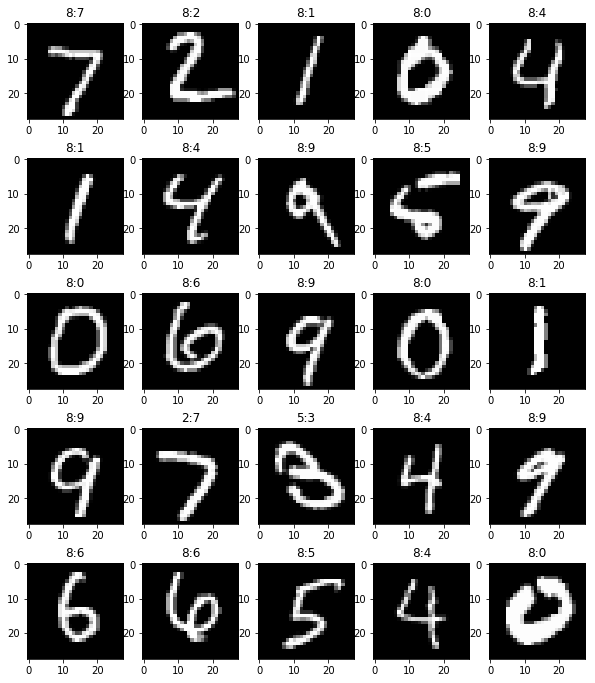

In [0]:
incorrect_idx_list = get_incorrect_im(X_test, 25)
print(len(incorrect_idx_list), incorrect_idx_list[:10])

fig = plt.figure(figsize=(10,12)) # width,height

first_incorrect_idx = incorrect_idx_list[0]
print("For first incorrect image :")
print("Predicted", pred_classes[first_incorrect_idx]) #, Y_pred[first_incorrect_idx])
print("Actual", test_classes[first_incorrect_idx]) #, Y_test[first_incorrect_idx])

for idx, val in enumerate(incorrect_idx_list):
  
  # Plot the original test image
  sub = fig.add_subplot(5, 5, idx+1) # nrows, ncols, index
  
  label = str(pred_classes[val]) + ":" + str(test_classes[val])
  sub.set_title(label)
  sub.imshow(x_test[val], cmap=plt.get_cmap('gray'))